In [3]:
### Dependencies instantiation ###

# Only run this cell once, if you haven't run it yet
# This ensures that you have all the necessary dependencies installed

using Pkg
Pkg.activate("../")
Pkg.instantiate()

  Activating project at `~/GitRepos/QuantumPrimer.jl`


In [ ]:
### Imports ###

include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using JLD2

function printt(x)
    show(stdout, "text/plain", x)
    println()
end

  Activating project at `~/GitRepos/QuantumPrimer.jl`


printt (generic function with 1 method)

#### Examples: run one cell

In [6]:
### Example: even vs odd states ###

using Combinatorics

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 8 # preferably a power of 2

all_vecs = collect(multiset_permutations(vcat(repeat([0], n), repeat([1], n)), n))
even_vecs = all_vecs[findall(j->iseven(count(i->i==1, all_vecs[j])), 1:length(all_vecs))]
odd_vecs = all_vecs[findall(j->isodd(count(i->i==1, all_vecs[j])), 1:length(all_vecs))]

n_samples = 20 # this is half of the total number of samples per dataset (2 datasets) due to cross classes. 4*n_samples total
n_samples <= length(even_vecs)÷4 || error("n_samples must be less than the number of even and odd vectors")

inds = randperm(trunc(Int, 2^n/2))[1:4n_samples]

psi_even = Vector{ArrayReg}(undef, 4n_samples)
psi_odd = Vector{ArrayReg}(undef, 4n_samples)
for i in 1:4*n_samples
    psi_even[i] = register_from_vector([even_vecs[inds[i]]])
    psi_odd[i] = register_from_vector([odd_vecs[inds[i]]])
end

states1 = Vector{NTuple{2, ArrayReg}}(undef, 2n_samples)
states2 = Vector{NTuple{2, ArrayReg}}(undef, 2n_samples)
for i in 1:n_samples
    states1[i] = (psi_even[i], psi_even[n_samples+i])
    states1[n_samples+i] = (psi_odd[i], psi_odd[n_samples+i])
    states2[i] = (psi_even[2n_samples+i], psi_odd[2n_samples+i])
    states2[n_samples+i] = (psi_odd[3n_samples+i], psi_even[3n_samples+i])
end

inds_sets = randperm(2n_samples) # half indices now because of "pair" datasets

# train
tr_states = vcat([states1[inds_sets[1:n_samples]], states2[inds_sets[1:n_samples]]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[inds_sets[1+n_samples:2n_samples]], states2[1+n_samples:2n_samples]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# # structures
d1 = DataSiamese(tr_states, tr_labels);
d2 = DataSiamese(te_states, te_labels);

#### Model parameters

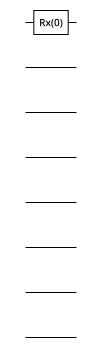

In [7]:
iters = 100 # number of iterations
lr = 0.02  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.

##### Cost #####
cost_fun = circ_swap_all
activation = x -> sigmoid(x, 10, 0.5) # default is identity
cost = CircuitCost(cost_fun, activation)
################

##### QCNN #####
# ansatz = circ_Ry_conv # circ_Ry_conv, circ_Ry_simple_conv, circ_SU4_conv
# circ1 = build_QCNN(n, ansatz=ansatz)
# circ2 = build_QCNN(n, ansatz=ansatz)
################

##### QNN #####
ansatze = Vector{Function}(undef, n)
for i in 1:n
    ansatze[i] = chain(put(i=>Rx(0)))
end
depth = 1
circs = Vector{ChainBlock}(undef, n)
for i in 1:n
    circs[i] = build_QNN(n, depth, ansatz=ansatze[i])
end
###############

##### Model #####
models = ntuple(i -> GeneralModel(n=n, circ=circs[i], ansatz=ansatze[i]), n)
for i in 1:n
    initialize_params!(models[i])
end
#################

YaoPlots.plot(circs[1])
# YaoPlots.plot(obs_A*obs_B)

#### tests

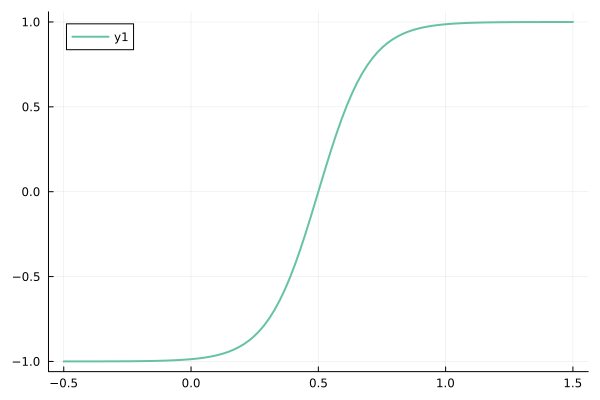

In [10]:
x_activation = LinRange(-0.5, 1.5, 100)
y_activation = activation.(x_activation)

Plots.plot(x_activation, y_activation)

In [11]:
rand(3, 3)

3×3 Matrix{Float64}:
 0.846298  0.0293418  0.399044
 0.155732  0.22251    0.444229
 0.338653  0.206663   0.498061

In [ ]:
n_test = 2

phi1 = rand_state(n_test ÷ 2)
phi2 = rand_state(n_test ÷ 2)
# phi2 = phi1

# B = rand_unitary(2^n_test)
B = rand(ComplexF64, 2^n_test, 2^n_test)
B = B / norm(B) * sqrt(2^n_test)
println("Norm of B: ", norm(B))

expect(circ_swap_all(n_test), join(phi2, phi1) |> matblock(B))

Norm of B: 2.0


1.2492239409237862

In [ ]:
lcu_circ = circ_LCU(n, [model.circ for model in models])

nqubits: 6
chain
├─ chain
│  ├─ put on (1)
│  │  └─ H
│  └─ put on (2)
│     └─ H
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        ├─ put on (1)
│        │  └─ X
│        └─ put on (2)
│           └─ X
├─ control(1, 2)
│  └─ (3, 4, 5, 6) chain
│     └─ chain
│        └─ put on (1)
│           └─ rot(X, 0.0)
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        ├─ put on (1)
│        │  └─ X
│        └─ put on (2)
│           └─ X
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        └─ put on (2)
│           └─ X
├─ control(1, 2)
│  └─ (3, 4, 5, 6) chain
│     └─ chain
│        └─ put on (2)
│           └─ rot(X, 0.0)
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        └─ put on (2)
│           └─ X
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        └─ put on (1)
│           └─ X
├─ control(1, 2)
│  └─ (3, 4, 5, 6) chain
│     └─ chain
│        └─ put on (3)
│           └─ rot(X, 0.0)
├─ chain
│  └─ put on (1, 2)
│     └─ chain
│        └─ put on (1)
│           └─ X
├─ chain
│  └

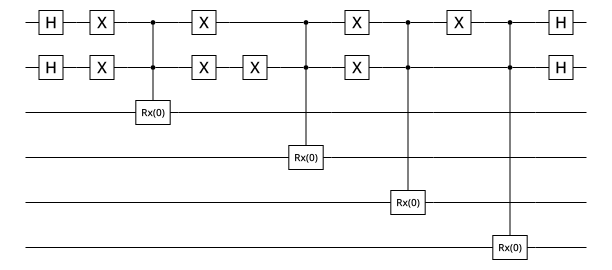

In [ ]:
lcu_circ |> YaoPlots.plot

In [ ]:
idx = 3

rho1 = states2[idx][1]
rho2 = states2[idx][2]

LCU = circ_LCU(n, [model.circ for model in models])
n_lcu = nqubits(LCU)
n_ancillas = n_lcu - n
n_models = length(models)
circ_full = chain(2n_lcu, put(1:n_lcu => LCU^n_models), put(n_lcu+1:2n_lcu => LCU^n_models))
SELECT0 = (I2 + Z) * 0.5  # project on |0>
circ_apply_LCU = chain(2n_lcu, repeat(SELECT0, vcat(collect(1:n_ancillas), collect(n_lcu+1:n_lcu+n_ancillas))))  # project onto 0 state on bottom registers to allow projection onto signed max vector
for model in models
    dispatch!(model.circ, expand_params(model))
end

println(expect(cost.cost(2n_lcu), join(uniform_state(n_ancillas), rho1, uniform_state(n_ancillas), rho2) |> circ_full |> circ_apply_LCU))
println(expect(cost.cost(2n_lcu), join(rho1, uniform_state(n_ancillas), rho2, uniform_state(n_ancillas)) |> circ_full |> circ_apply_LCU))

8.486990169700368e-8
1.9615732052097992e-35


In [ ]:
states1[1]

(ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2)

In [ ]:
eval_loss(tr_states[1], models, cost)

QubitMismatchError: register size 8 mismatch with block size 12

In [ ]:
LCU = sum([model.circ for model in models])

nqubits: 4
+
├─ chain
│  └─ chain
│     └─ put on (1)
│        └─ rot(X, 4.288479195197181)
├─ chain
│  └─ chain
│     └─ put on (2)
│        └─ rot(X, 6.011380704980616)
├─ chain
│  └─ chain
│     └─ put on (3)
│        └─ rot(X, 4.070595001235916)
└─ chain
   └─ chain
      └─ put on (4)
         └─ rot(X, 6.262232715337117)


In [ ]:
n_models = length(models)
circ_full = chain(2n, put(1:n => LCU^n_models), put(n+1:2n => LCU^n_models))


nqubits: 8
chain
├─ put on (1, 2, 3, 4)
│  └─ chain
│     ├─ +
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (1)
│     │  │        └─ rot(X, 4.288479195197181)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (2)
│     │  │        └─ rot(X, 6.011380704980616)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (3)
│     │  │        └─ rot(X, 4.070595001235916)
│     │  └─ chain
│     │     └─ chain
│     │        └─ put on (4)
│     │           └─ rot(X, 6.262232715337117)
│     ├─ +
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (1)
│     │  │        └─ rot(X, 4.288479195197181)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (2)
│     │  │        └─ rot(X, 6.011380704980616)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (3)
│     │  │        └─ rot(X, 4.070595001235916)
│     │  └─ chain
│     │     └─ chain
│     │        └─ put on (4)
│     │           └─ rot(X, 6.262232715337117)
│     

In [ ]:
for model in models
    dispatch!(model.circ, expand_params(model))
end

In [ ]:
circ_full

nqubits: 8
chain
├─ put on (1, 2, 3, 4)
│  └─ chain
│     ├─ +
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (1)
│     │  │        └─ rot(X, 4.288479195197181)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (2)
│     │  │        └─ rot(X, 6.011380704980616)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (3)
│     │  │        └─ rot(X, 4.070595001235916)
│     │  └─ chain
│     │     └─ chain
│     │        └─ put on (4)
│     │           └─ rot(X, 6.262232715337117)
│     ├─ +
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (1)
│     │  │        └─ rot(X, 4.288479195197181)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (2)
│     │  │        └─ rot(X, 6.011380704980616)
│     │  ├─ chain
│     │  │  └─ chain
│     │  │     └─ put on (3)
│     │  │        └─ rot(X, 4.070595001235916)
│     │  └─ chain
│     │     └─ chain
│     │        └─ put on (4)
│     │           └─ rot(X, 6.262232715337117)
│     

In [ ]:
norm(Matrix(circ_full))

21724.425420908403

In [ ]:
norm(I(256))

16.0

In [ ]:
norm(rand_unitary(256))

16.0

In [ ]:
16^2

256

In [ ]:
tr_states

4-element Vector{Tuple{ArrayReg, ArrayReg}}:
 (ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2)
 (ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2)
 (ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2)
 (ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2)

In [ ]:
idx = 1

expect(cost.cost(2n)/norm(Matrix(circ_full))*16, join(tr_states[idx][1], tr_states[idx][2]) |> circ_full)

1282.0615545172327

#### Run

In [ ]:
model_results = train_test_model(d1, d2, models, cost, iters, optim; regularization=:nothing, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-2, regularization=:l1, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-5, regularization=:l2, verbose=true);

models_trained, loss_track, tr_track, te_track, tr_preds, te_preds = model_results;

#### Plot

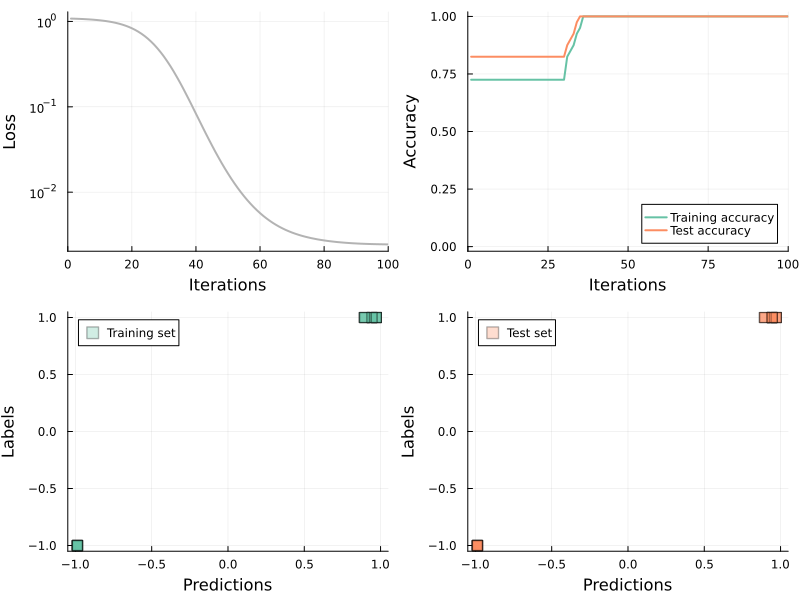

In [9]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [29]:
# savefig("qcsnn_forr_n4_conv_Ry_overlap.pdf")

In [15]:
@save "models_trained.jld2" models_trained

In [ ]:
@load "models_trained.jld2" models_trained

1-element Vector{Symbol}:
 :models_trained

In [ ]:
for model in models_trained
    println(model.params)
end

[2.7557533215301904]
[3.143885967114019]
[3.1473655140152985]
[3.126115234628496]
[3.15351888146707]
[3.152616636995633]
[3.19522869568465]
[3.149642002078508]
